If you want to see more visualizations, please go to [notebook](https://www.kaggle.com/jswxhd/eda-strategies-for-different-data-attributtes). :)

In [1]:
import numpy as np 
import pandas as pd
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import confusion_matrix,precision_recall_curve
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import xgboost as xgb 
from xgboost import XGBClassifier

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
raw_data = pd.read_csv('../input/credit-card-customers/BankChurners.csv')
raw_data.drop(columns=['CLIENTNUM',
                       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                       'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
          axis=1,inplace=True)
raw_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Data Preprocessing

## Ordinal Encoding and one-hot Encoding

Ordinal features like 'Education_Level' can be encoded with ordinal values to reduce dimension.
Nominal features like 'Marital_Status' is encoded with one-hot encoding.

For unknown values in the feature 'Education_Level' and 'Income_Category', I encode them as np.nan for further imputation. For unknown values in the feature 'Marital_Status', I treat it as a separate category.

In [3]:
data = raw_data.copy()
data['Attrition_Flag'] = data['Attrition_Flag'].apply(lambda x: 1 if x=='Attrited Customer' else 0)
data['Gender'] = data['Gender'].apply(lambda x: 1 if x=='F' else 0)

edu_dict = {'Unknown':np.nan,'Uneducated':0,'High School':1,'College':2,
             'Graduate':3,'Post-Graduate':4,'Doctorate':5}
data['Education_Level'] = data['Education_Level'].apply(lambda x: edu_dict[x])

marital_onehot = pd.get_dummies(data['Marital_Status'],prefix='Marital_Status')
data = pd.concat([data,marital_onehot],axis=1)
data.drop(columns=['Marital_Status','Marital_Status_Unknown'],axis=1,inplace=True)

income_dict = {'Unknown':np.nan,'Less than $40K':0,'$40K - $60K':1,
                '$60K - $80K':2,'$80K - $120K':3,'$120K +':4}
data['Income_Category'] = data['Income_Category'].apply(lambda x: income_dict[x])

Split train and test data in order to use further encoding and imputation methods.

In [4]:
X = data.drop(columns='Attrition_Flag',axis=1)
y = data['Attrition_Flag']
train_x,test_x,train_y,test_y = train_test_split(X,y,test_size=0.2, shuffle=True, random_state=42)

## Count Encoding 

I think count encoding is suitable for the feature 'Card_Category' because value 'Blue' take the dominant place.

In [5]:
count_enc = ce.CountEncoder(cols='Card_Category')
count_encoded = count_enc.fit(train_x['Card_Category'])
train_x = train_x.join(count_encoded.transform(train_x['Card_Category']).add_suffix('_count'))
test_x = test_x.join(count_encoded.transform(test_x['Card_Category']).add_suffix('_count'))
train_x.drop(columns='Card_Category',axis=1,inplace=True)
test_x.drop(columns='Card_Category',axis=1,inplace=True)

## Impute Missing Values with KNNImputer

From my points of view, null values exist in features 'Education_Level' and 'Income_Category' because they were not recorded. Hence, dropping them directly is not a wise choice. Instead we should use imputing method.

In [6]:
Imputer = KNNImputer(missing_values = np.nan, n_neighbors=1, weights='uniform').fit(train_x)
imputed_train_x = Imputer.transform(train_x)
imputed_test_x = Imputer.transform(test_x)

In [7]:
np.sum(np.isnan(imputed_train_x)),np.sum(np.isnan(imputed_test_x))

(0, 0)

Imputing is done successfully.

## Check Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

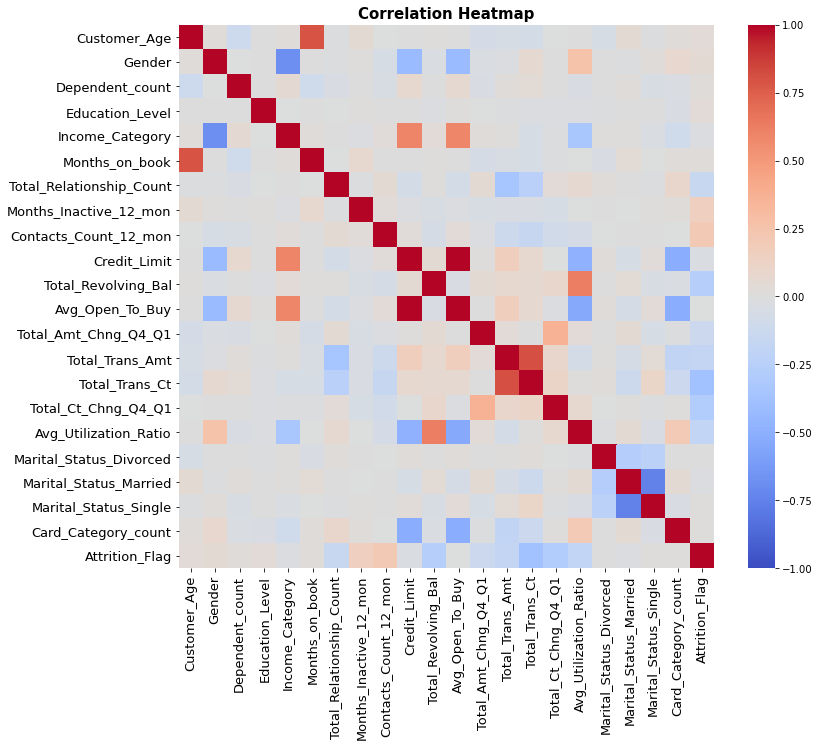

In [8]:
imputed_train = np.column_stack((imputed_train_x,train_y))
df_imputed_train = pd.DataFrame(imputed_train)
df_imputed_train.columns = list(train_x.columns) + ['Attrition_Flag']

corr = df_imputed_train.corr()
fig,ax = plt.subplots(figsize=(12,10))
sns.heatmap(corr,ax=ax,vmin=-1, vmax=1, cmap='coolwarm', annot=False)
plt.yticks(rotation=0,fontsize=13)
plt.xticks(rotation=90,fontsize=13)
ax.set_title('Correlation Heatmap',fontsize=15,fontweight='bold')

1. There is highly positively correlation between 'Avg_Open_To_Buy' and 'Credit_Limit'.
2. There is highly negatively correlation betweern 'Marital_Status_Single' and 'Marital_Status_Married'.

In [9]:
columns = np.full(shape=(corr.shape[0],), fill_value=True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if abs(corr.iloc[i,j]) >= 0.9:
            if columns[j]:
                columns[j] = False
sel_columns = df_imputed_train.columns[columns]
df_imputed_train = df_imputed_train[sel_columns]
df_imputed_train.columns

Index(['Customer_Age', 'Gender', 'Dependent_count', 'Education_Level',
       'Income_Category', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit',
       'Total_Revolving_Bal', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt',
       'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio',
       'Marital_Status_Divorced', 'Marital_Status_Married',
       'Marital_Status_Single', 'Card_Category_count', 'Attrition_Flag'],
      dtype='object')

Feature 'Avg_Open_To_Buy' is dropped because highly correlate with the feature 'Credit_Limit'.

In [10]:
cleaned_train_x = df_imputed_train.drop(columns='Attrition_Flag',axis=1)
df_imputed_test_x = pd.DataFrame(imputed_test_x)
df_imputed_test_x.columns = test_x.columns
cleaned_test_x = df_imputed_test_x.drop(columns='Avg_Open_To_Buy',axis=1)

# Modeling

## SMOTE + XGBoost

In [11]:
y_cnt_before = train_y.value_counts()
trace = go.Pie(labels = y_cnt_before.index, 
               values = y_cnt_before.values,
               hoverinfo = 'percent+value+label',
               textinfo = 'percent',
               textposition = 'inside',
               textfont = dict(size=14),
               title = 'Attrition Flag',
               titlefont = dict(size=15),
               hole = 0.5,
               showlegend = True,
               marker = dict(line=dict(color='black',width=2)))
fig = go.Figure(data=[trace])
fig.update_layout(height=500, width=500)
fig.show()

Combine oversampling for minor class with undersampling for major class.

In [12]:
over_sampling = SMOTE(sampling_strategy=0.4, k_neighbors=5, random_state=42)
under_sampling = RandomUnderSampler(sampling_strategy=0.5, random_state=42)
pipeline = Pipeline(steps=[('o',over_sampling),('u',under_sampling)])
ou_train_x,ou_train_y = pipeline.fit_resample(cleaned_train_x,train_y)

In [13]:
y_cnt_after = ou_train_y.value_counts()
trace = go.Pie(labels = y_cnt_after.index, 
               values = y_cnt_after.values,
               hoverinfo = 'percent+value+label',
               textinfo = 'percent',
               textposition = 'inside',
               textfont = dict(size=14),
               title = 'Attrition Flag',
               titlefont = dict(size=15),
               hole = 0.5,
               showlegend = True,
               marker = dict(line=dict(color='black',width=2)))
fig = go.Figure(data=[trace])
fig.update_layout(height=500, width=500)
fig.show()

Customize evaluation function 'reversed recall'

In [14]:
def rev_recall(pred,dtrain):
    labels = dtrain.get_label()
    pred = np.round(1.0 / (1.0 + np.exp(-pred)))
    cm = confusion_matrix(labels, pred)
    recall =float(cm[1][1]) / float(cm[1][0]+cm[1][1])
    reversed_recall = 1-recall
    return 'Reversed-Recall',reversed_recall

In [15]:
baseline_params = {'n_estimators': 500,
                   'max_depth': 8,
                   'learning_rate': 0.3,
                   'subsample': 0.8,
                   'colsample_by_tree': 0.6,
                   'min_child_weight':7,
                   'verbosity' :1,
                   'random_state': 42}

baseline_xgb = xgb.XGBClassifier(**baseline_params)
baseline_xgb.fit(ou_train_x,ou_train_y, eval_metric=rev_recall,
                 eval_set=[(ou_train_x,ou_train_y),(cleaned_test_x,test_y)], 
                 early_stopping_rounds=10,verbose=1)

[00:42:09] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.06740	validation_1-error:0.07354	validation_0-Reversed-Recall:0.12647	validation_1-Reversed-Recall:0.17431
Multiple eval metrics have been passed: 'validation_1-Reversed-Recall' will be used for early stopping.

Will train until validation_1-Reversed-Recall hasn't improved in 10 rounds.
[1]	validation_0-error:0.05515	validation_1-error:0.07157	validation_0-Reversed-Recall:0.07610	validation_1-Reversed-Recall:0.12844
[2]	validation_0-error:0.04804	validation_1-error:0.06466	validation_0-Reversed-Recall:0.07243	validation_1-Reversed-Recall:0.11927
[3]	validation_0-error:0.04448	validation_1-error:0.06466	validation_0-Reversed-Recall

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.6,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=1)

Text(0.5, 1.0, 'Confusion Matrix on Test Data')

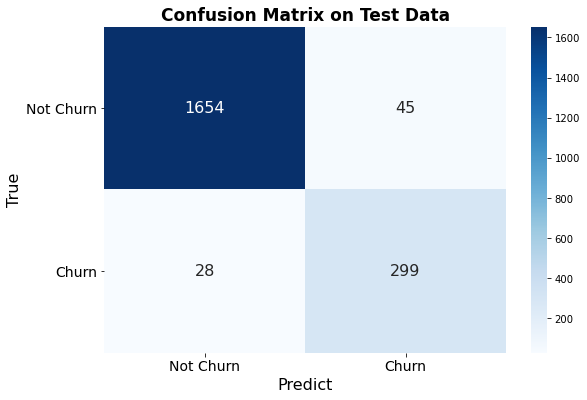

In [16]:
pred_y = baseline_xgb.predict(cleaned_test_x)

fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(confusion_matrix(test_y,pred_y),ax=ax,
            annot=True, fmt='d',annot_kws={'size':16},cmap='Blues')
ax.set_xticklabels(['Not Churn','Churn'],fontsize=14)
ax.set_yticklabels(['Not Churn','Churn'],fontsize=14,rotation=0)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('True',fontsize=16)
ax.set_title('Confusion Matrix on Test Data', fontsize=17, fontweight='bold')

Recall is 92% in baseline model :)

Text(0.5, 1.0, 'Feature Importance')

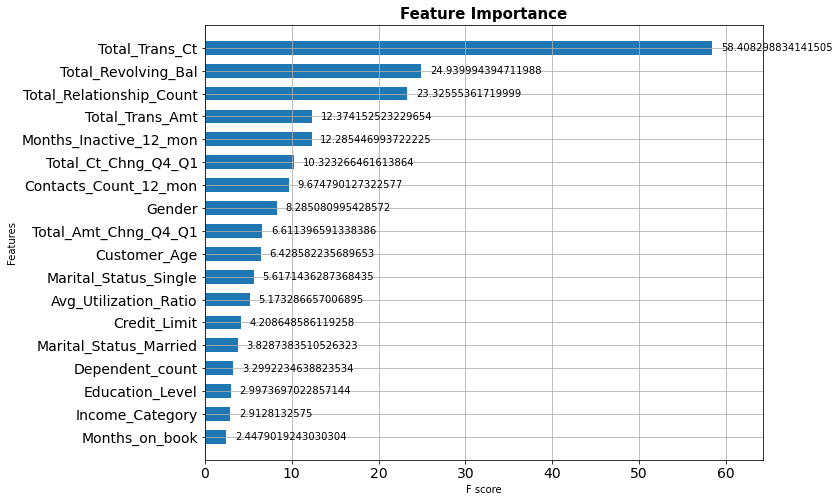

In [17]:
fig,ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(baseline_xgb,ax=ax,importance_type='gain',height=0.6, max_num_features=None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Feature Importance',fontsize=15,fontweight='bold')

## XGBoost + Change Class Weight

In [18]:
baseline_params_2 = {'n_estimators': 500,
                   'max_depth': 8,
                   'learning_rate': 0.3,
                   'subsample': 0.8,
                   'colsample_by_tree': 0.6,
                   'min_child_weight':7,
                   'verbosity' :1,
                   'scale_pos_weight':3,
                   'random_state': 42}

xgb_2 = xgb.XGBClassifier(**baseline_params_2)
xgb_2.fit(cleaned_train_x,train_y, eval_metric=rev_recall,
                 eval_set=[(cleaned_train_x,train_y),(cleaned_test_x,test_y)], 
                 early_stopping_rounds=10,verbose=1)

[00:42:12] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.06098	validation_1-error:0.07404	validation_0-Reversed-Recall:0.09000	validation_1-Reversed-Recall:0.13150
Multiple eval metrics have been passed: 'validation_1-Reversed-Recall' will be used for early stopping.

Will train until validation_1-Reversed-Recall hasn't improved in 10 rounds.
[1]	validation_0-error:0.04666	validation_1-error:0.06367	validation_0-Reversed-Recall:0.07615	validation_1-Reversed-Recall:0.13150
[2]	validation_0-error:0.03925	validation_1-error:0.05874	validation_0-Reversed-Recall:0.06000	validation_1-Reversed-Recall:0.11009
[3]	validation_0-error:0.03666	validation_1-error:0.05331	validation_0-Reversed-Recall

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.6,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=3, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=1)

Text(0.5, 1.0, 'Confusion Matrix on Test Data')

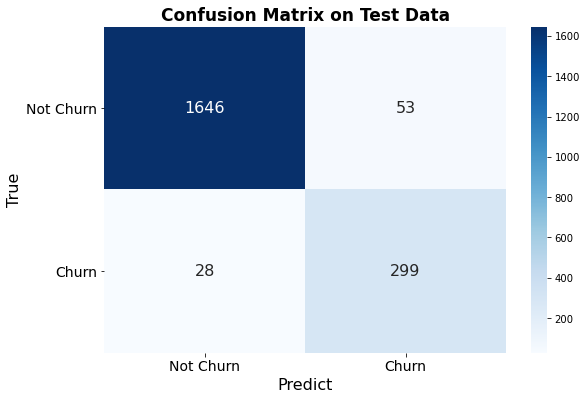

In [19]:
pred_y_2 = xgb_2.predict(cleaned_test_x)

fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(confusion_matrix(test_y,pred_y_2),ax=ax,
            annot=True, fmt='d',annot_kws={'size':16},cmap='Blues')
ax.set_xticklabels(['Not Churn','Churn'],fontsize=14)
ax.set_yticklabels(['Not Churn','Churn'],fontsize=14,rotation=0)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('True',fontsize=16)
ax.set_title('Confusion Matrix on Test Data', fontsize=17, fontweight='bold')

Although the recall is the same as I get in SMOTE+XGBoost, the precision goes down a little. It is the side effect of changing class weight when modeling.

Text(0.5, 1.0, 'Feature Importance')

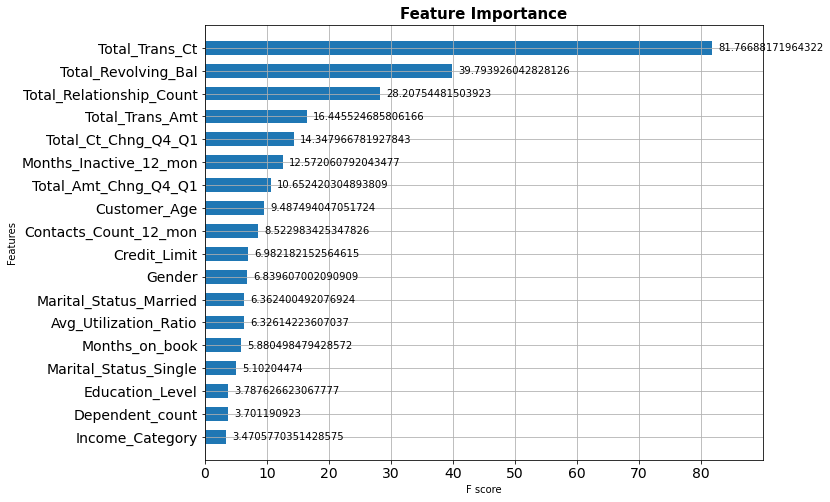

In [20]:
fig,ax = plt.subplots(figsize=(10,8))
xgb.plot_importance(xgb_2,ax=ax,importance_type='gain',height=0.6, max_num_features=None)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.set_title('Feature Importance',fontsize=15,fontweight='bold')

## XGBoost + Threshold Moving

In [21]:
baseline_params_3 = {'n_estimators': 500,
                   'max_depth': 8,
                   'learning_rate': 0.3,
                   'subsample': 0.8,
                   'colsample_by_tree': 0.6,
                   'min_child_weight':7,
                   'verbosity' :1,
                   'random_state': 42}

xgb_3 = xgb.XGBClassifier(**baseline_params_3)
xgb_3.fit(cleaned_train_x,train_y, eval_metric=rev_recall,
                 eval_set=[(cleaned_train_x,train_y),(cleaned_test_x,test_y)], 
                 early_stopping_rounds=10,verbose=1)

[00:42:15] WARNING: ../src/learner.cc:516: 
Parameters: { colsample_by_tree } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-error:0.05715	validation_1-error:0.06861	validation_0-Reversed-Recall:0.19846	validation_1-Reversed-Recall:0.24771
Multiple eval metrics have been passed: 'validation_1-Reversed-Recall' will be used for early stopping.

Will train until validation_1-Reversed-Recall hasn't improved in 10 rounds.
[1]	validation_0-error:0.04876	validation_1-error:0.06071	validation_0-Reversed-Recall:0.19077	validation_1-Reversed-Recall:0.24465
[2]	validation_0-error:0.04358	validation_1-error:0.05726	validation_0-Reversed-Recall:0.17539	validation_1-Reversed-Recall:0.23242
[3]	validation_0-error:0.03913	validation_1-error:0.05331	validation_0-Reversed-Recall

XGBClassifier(base_score=0.5, booster='gbtree', colsample_by_tree=0.6,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.3, max_delta_step=0,
              max_depth=8, min_child_weight=7, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=0,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=1)

**Precision Recall curve and F-score** are chosen to find the best threshold because they reveal the model performance well when the dataset is imbalanced.

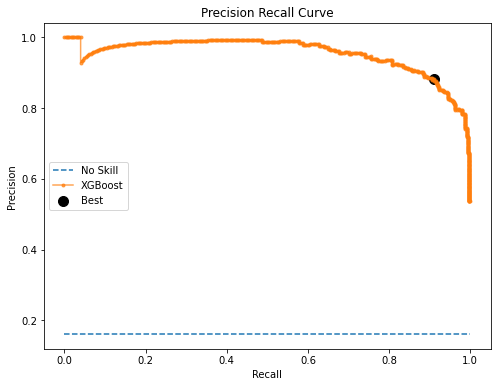

In [22]:
pred_y_3 = xgb_3.predict_proba(cleaned_test_x)
class_1_proba = pred_y_3[:,1]
precision, recall, thresholds = precision_recall_curve(test_y, class_1_proba)
f_score = (2*precision*recall)/(precision+recall)
idx = np.argmax(f_score)

no_skill = np.sum(test_y) / len(test_y)
fig,ax = plt.subplots(figsize=(8,6))
ax.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
ax.plot(recall, precision, marker='.', label='XGBoost',alpha=0.7)
ax.scatter(recall[idx], precision[idx], s=100, marker='o', color='black', label='Best')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall Curve')
ax.legend(loc='center left')

In [23]:
print('best threshold is %f' % (thresholds[idx]))

best threshold is 0.361663


Text(0.5, 1.0, 'Confusion Matrix on Test Data')

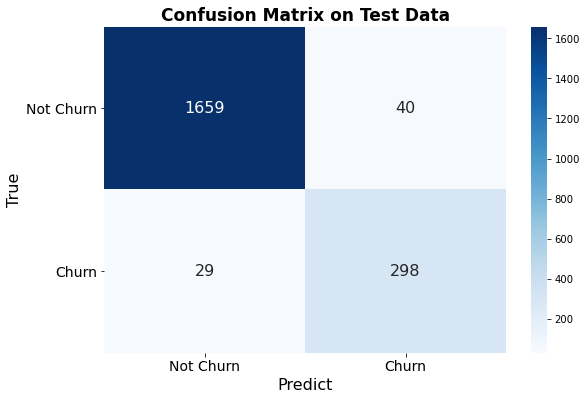

In [24]:
best_threshold = thresholds[idx]
final_pred_y_3 = [1 if p>=best_threshold else 0 for p in class_1_proba]

fig,ax = plt.subplots(figsize=(9,6))
sns.heatmap(confusion_matrix(test_y,final_pred_y_3),ax=ax,
            annot=True, fmt='d',annot_kws={'size':16},cmap='Blues')
ax.set_xticklabels(['Not Churn','Churn'],fontsize=14)
ax.set_yticklabels(['Not Churn','Churn'],fontsize=14,rotation=0)
ax.set_xlabel('Predict',fontsize=16)
ax.set_ylabel('True',fontsize=16)
ax.set_title('Confusion Matrix on Test Data', fontsize=17, fontweight='bold')

# Conclusion 

In [25]:
all_recalls = [float(confusion_matrix(test_y,y_hat)[1][1]/np.sum(confusion_matrix(test_y,y_hat),axis=1)[1]) 
               for y_hat in [pred_y,pred_y_2,final_pred_y_3]]
all_precisions = [float(confusion_matrix(test_y,y_hat)[1][1]/np.sum(confusion_matrix(test_y,y_hat),axis=0)[1]) 
                  for y_hat in [pred_y,pred_y_2,final_pred_y_3]]
all_acc = [float((confusion_matrix(test_y,y_hat)[1][1]+confusion_matrix(test_y,y_hat)[0][0])/len(test_y)) 
           for y_hat in [pred_y,pred_y_2,final_pred_y_3]]
all_methods = ['SMOTE','Change Class Weight','Move Threshold']

As the result shown below, Recall for all three methods are almost the same. Precision and accuracy is the highest when using the method of moving threshold. From my point of view, resampling data and moving threshold are both good choices when dealing with imbalanced data. Drawback of Changing class weight is that precison will be sacrificed. 

In [26]:
fig = go.Figure(data=[go.Table(header=dict(values=['Method','Recall', 'Precision','Accuracy'], 
                               fill_color='yellow', line_color='black'),
                               cells=dict(values=[all_methods,all_recalls,all_precisions,all_acc], 
                               fill_color='lavender', line_color='black'))])
fig.update_layout(width=800,height=700)
fig.show()